In [10]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
# import torch.multiprocessing as mp
from class_models import early_stop

In [11]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cpu


##  Schedule to find the average number of epochs 
Using K-Fold Cross-Validation I use a Training Loop to find an average number of epochs using early stopping 

### Data Processing

In [12]:
# import data
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [13]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):

    # average radius of the Earth in (km)
    r = 6371

    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)

    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()

    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])

    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)

    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")

    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')

    dfd = dfd.drop(columns=['pickup_datetime'])

    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """

    # group the data in categorical continuous and target label
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64).to(device)
    conts_t = torch.tensor(conts, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)

    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]

    return emb_sizes


In [14]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['dist_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [37]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### K-folds function generator
Since the *train_index* and the *val_index* are those who effectively creates the training subsets we can create all the six subsets: 2 for categorical, 2 for continuous and 2 for y labels.

In [38]:
# Function-generator to split the data into k folds
def kfold_split(k, X_cat, X_cont, y):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_cat):
        X_cat_train, X_cat_val = X_cat[train_index], X_cat[val_index]
        X_cont_train, X_cont_val = X_cont[train_index], X_cont[val_index]
        y_train, y_val = y[train_index], y[val_index]
        yield X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val

### Training hyperparameters

In [39]:
# Experiment with different dropout rates
arch_configs = [
    ([400, 300, 200, 100], 0.2),
]

out_size = 1
batch_size = 128
epochs = 200
results_kfold = []
k = 6

### Cross-Validation Loop

In [40]:
for arch, p in arch_configs:
    fold = 0

    print(f"Testing architecture: {arch} with dropout: {p}")

    for X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val in kfold_split(k, cats, conts, y):
        fold += 1
        print(f"Fold {fold}/{k}")

        # Create datasets and loaders
        train_dataset = TensorDataset(X_cat_train, X_cont_train, y_train)
        val_dataset = TensorDataset(X_cat_val, X_cont_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, optimizer, and scheduler
        model = TabularModel(emb_sizes, n_cont, out_size, arch, p).to(device)
        criterion = nn.SmoothL1Loss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        early_stopping = early_stop.EarlyStopping(patience=100)

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_losses = []

            for X_cat_batch, X_cont_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_cat_batch, X_cont_batch)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = [] 
            with torch.no_grad():
                for X_cat_batch, X_cont_batch, y_batch in val_loader:
                    y_pred = model(X_cat_batch, X_cont_batch)
                    loss = torch.sqrt(criterion(y_pred, y_batch))
                    val_losses.append(loss.item())

            mean_val_loss = np.mean(val_losses)
            mean_train_loss = np.mean(train_losses)
            

            # evaluates the error over the entire k-fold validation data
            with torch.no_grad():
                r_y_hat = model(X_cat_val, X_cont_val).flatten()
                r_loss = torch.sqrt(criterion(r_y_hat, y_val.flatten())).item()

            if epoch % 20 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, T.L.: {mean_train_loss:.4f}, V.L.: {mean_val_loss:.4f}, TRSE: {r_loss:.4f}, E.S.:{early_stopping.status}")

            # Save results for the current fold and configuration
            results_kfold.append({
                "Fold": fold,
                "Epoch": epoch + 1,
                "Train Loos": mean_train_loss,
                "Validation Loss": mean_val_loss,
                "Total Root SmoothL1 Error": r_loss,
            })
            
            # Check early stopping
            if early_stopping(model, mean_val_loss):  # Pass the latest validation loss to early stopping
                print(early_stopping.status)
                break

Testing architecture: [400, 300, 200, 100] with dropout: 0.2
Fold 1/6
Epoch 1/200, T.L.: 1.5981, V.L.: 1.0687, TRSE: 1.0739, E.S.:
Epoch 21/200, T.L.: 1.0376, V.L.: 0.9225, TRSE: 0.9285, E.S.:Improvement!!!, actual counter 2
Epoch 41/200, T.L.: 1.0140, V.L.: 0.9150, TRSE: 0.9210, E.S.:NO improvement in the last 6 epochs
Epoch 61/200, T.L.: 1.0090, V.L.: 0.9070, TRSE: 0.9132, E.S.:NO improvement in the last 2 epochs
Epoch 81/200, T.L.: 1.0001, V.L.: 0.8988, TRSE: 0.9051, E.S.:NO improvement in the last 13 epochs
Epoch 101/200, T.L.: 0.9888, V.L.: 0.9015, TRSE: 0.9077, E.S.:NO improvement in the last 33 epochs

Fold 2/6
Epoch 1/200, T.L.: 1.5854, V.L.: 1.0520, TRSE: 1.0578, E.S.:
Epoch 21/200, T.L.: 1.0318, V.L.: 0.9484, TRSE: 0.9541, E.S.:NO improvement in the last 2 epochs
Epoch 41/200, T.L.: 1.0153, V.L.: 0.9307, TRSE: 0.9359, E.S.:NO improvement in the last 11 epochs
Epoch 61/200, T.L.: 1.0010, V.L.: 0.9213, TRSE: 0.9271, E.S.:NO improvement in the last 2 epochs
Epoch 81/200, T.L.: 0

In [51]:
results_df = pd.DataFrame(results_kfold)
results_df.to_csv("export/results_epochs.csv", index=False)

In [43]:
results_df.head(10)

,Fold,Epoch,Train Loos,Validation Loss,Total Root SmoothL1 Error
0,1,1,1.598142,1.068736,1.073889
1,1,2,1.163066,1.010976,1.016326
2,1,3,1.122007,0.981230,0.986709
3,1,4,1.103903,0.966312,0.971797
4,1,5,1.085883,0.954368,0.960165
5,1,6,1.074190,0.957755,0.963657
6,1,7,1.069561,0.945584,0.951463
7,1,8,1.063518,0.979300,0.985196
8,1,9,1.059652,0.930550,0.936367
9,1,10,1.057067,0.929294,0.935214


In [47]:
df_grouped = results_df.groupby('Fold').max().reset_index()
mean_epochs = df_grouped['Epoch'].mean()

In [50]:
print(mean_epochs)

151.83333333333334


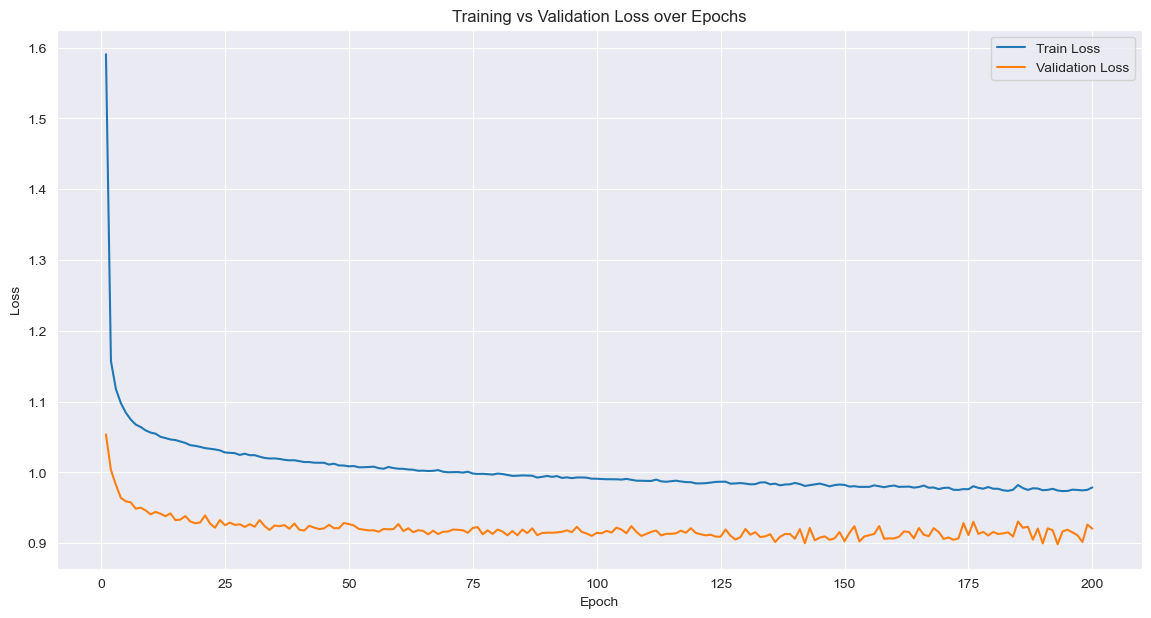

In [57]:
# Rename the column in the DataFrame if necessary
results_df.rename(columns={"Train Loos": "Train Loss"}, inplace=True)

# Now, generate the plot with the correct column names
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Train Loss', label='Train Loss', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='Validation Loss', label='Validation Loss', errorbar=None)
plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

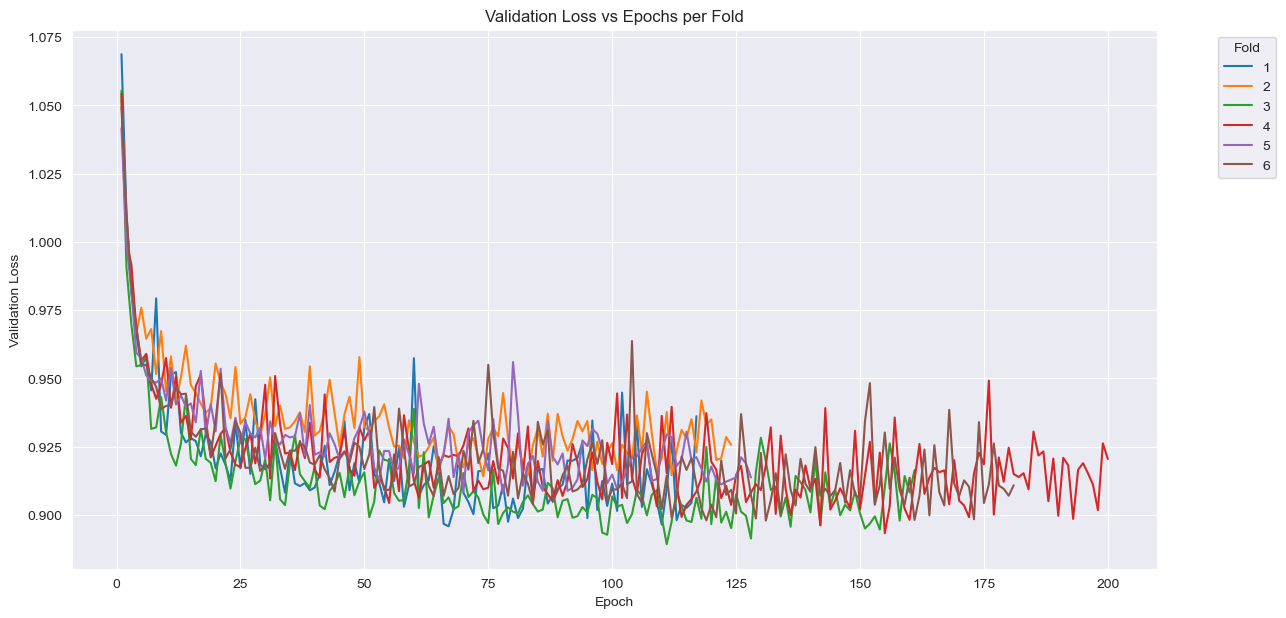

In [54]:
# 2. Validation Loss vs Epochs per Fold
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Validation Loss', hue='Fold', palette='tab10', errorbar=None)
plt.title('Validation Loss vs Epochs per Fold')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Fold', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

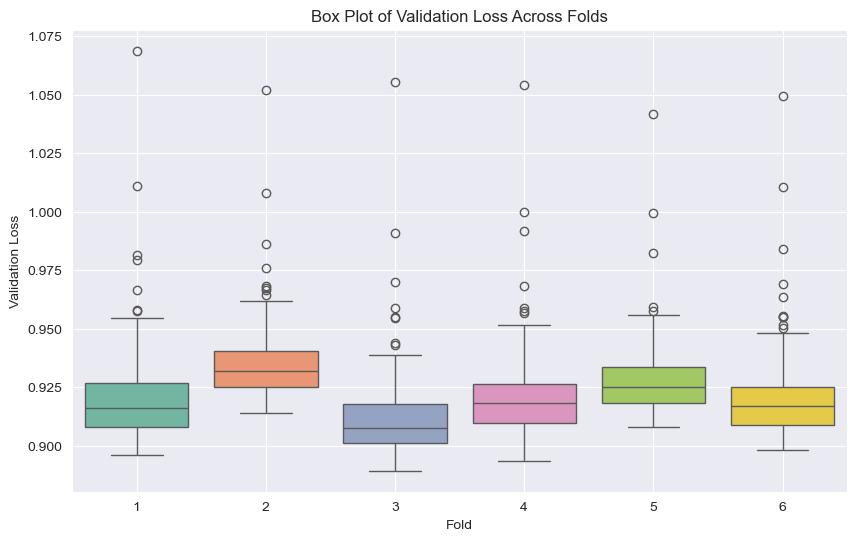

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Fold', y='Validation Loss', hue='Fold', palette='Set2', dodge=False)
plt.title('Box Plot of Validation Loss Across Folds')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend([],[], frameon=False)  # Hide the legend
plt.show()

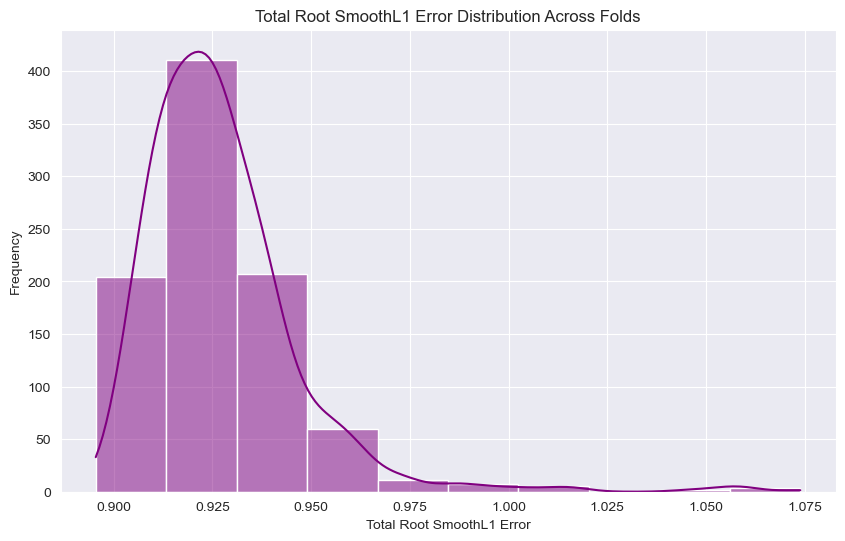

In [59]:
# 4. Total Root SmoothL1 Error Distribution Across Folds
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Total Root SmoothL1 Error', kde=True, bins=10, color='purple')
plt.title('Total Root SmoothL1 Error Distribution Across Folds')
plt.xlabel('Total Root SmoothL1 Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()